In [1]:
import numpy as np 
import pandas as pd 
import matplotlib
import statsmodels.api as sm 
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 10) #For displaying max 10 rows 

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings("ignore")


In [2]:
city = pd.read_csv('Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')

# Filter Data for Colorado

In [3]:
coldf = city[city['StateName'] == 'CO']

In [4]:
coldf.Metro.nunique()

17

In [5]:
coldf.CountyName.nunique()

63

In [6]:
coldf['RegionName'] = coldf['City'] 

In [7]:
coldf.drop(['State','City','Metro','CountyName'],axis=1,inplace=True)

In [8]:
coldf.rename(columns = {'RegionName':'City'}, inplace = True)

# Cleaned and Filtered Data

In [9]:
coldf

,RegionID,SizeRank,City,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31
99,93263,100,Parker,Zip,CO,256849.0,258048.0,259620.0,262785.0,266244.0,...,664500.0,674933.0,687309.0,700448.0,720435.0,735422.0,749450.0,752333.0,752067.0,744450.0
171,93203,173,Aurora,Zip,CO,170965.0,172539.0,173614.0,176149.0,178200.0,...,475951.0,482666.0,491113.0,502255.0,513093.0,525547.0,533779.0,541139.0,541344.0,537865.0
233,93490,235,Greeley,Zip,CO,184378.0,184621.0,183767.0,183048.0,182865.0,...,437102.0,442695.0,446758.0,450883.0,458887.0,469284.0,481308.0,487882.0,491289.0,490224.0
322,93205,324,Aurora,Zip,CO,206724.0,208610.0,209842.0,212834.0,215234.0,...,541677.0,549426.0,559504.0,572231.0,584176.0,597715.0,607299.0,615903.0,617123.0,613693.0
326,93449,328,Fort Collins,Zip,CO,196865.0,196517.0,197267.0,198417.0,200332.0,...,532241.0,538915.0,547723.0,557210.0,566742.0,575591.0,586157.0,596794.0,603358.0,603373.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27341,93398,33114,Grant,Zip,CO,158992.0,158127.0,158862.0,159426.0,161929.0,...,518102.0,524636.0,535514.0,547220.0,554353.0,557435.0,559918.0,581230.0,600737.0,616584.0
27344,93378,33238,Pine,Zip,CO,NaN,NaN,NaN,NaN,NaN,...,NaN,637744.0,649932.0,661717.0,675245.0,689002.0,702546.0,713151.0,717590.0,717919.0
27354,399645,33802,Colorado Springs,Zip,CO,NaN,NaN,NaN,NaN,NaN,...,463983.0,458189.0,455962.0,461317.0,471206.0,480758.0,491435.0,500347.0,509513.0,516881.0
27362,93808,34302,Grand Junction,Zip,CO,NaN,NaN,NaN,NaN,NaN,...,514610.0,519702.0,523654.0,531320.0,539841.0,552918.0,564189.0,571418.0,574742.0,577068.0


# Checked for NaN values and filled with back fill 

In [10]:
# Checking our dataframe for NaN values
print(f'There are {coldf.isna().sum().sum()} NaNs in our original dataframe')

# Backfilling that single NaN
coldf.fillna(method='bfill', inplace=True)

# Sanity check
print(f'There are {coldf.isna().sum().sum()} NaNs after using backfill')

There are 23074 NaNs in our original dataframe
There are 0 NaNs after using backfill


# Function that converts data into the format it should be for estimating city house prices.

In [11]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID', 'SizeRank', 'City', 'RegionType', 'StateName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

# Above function has been implemented for each city

In [12]:
df = pd.DataFrame()
for i in coldf['City']:
    x = melt_data(coldf[coldf['City'] == i])
    df = pd.concat([df, x], axis=1)
    df.rename(columns = {'value':i}, inplace = True)
    
df.head()

,Parker,Aurora,Greeley,Aurora,Fort Collins,Aurora,Longmont,Denver,Loveland,Broomfield,...,Karval,Ohio City,Hamilton,Vernon,Meredith,Grant,Pine,Colorado Springs,Grand Junction,Mount Crested Butte
time,,,,,,,,,,,,,,,,,,,,,
2000-01-31,263441.5,184265.0,163148.5,184265.0,198286.0,184265.0,223881.333333,202976.107143,191099.5,251546.0,...,158992.0,158992.0,158992.0,158992.0,158992.0,158992.0,195571.5,171756.954545,158457.571429,168509.0
2000-02-29,264700.5,185778.3,163477.5,185778.3,198046.2,185778.3,224889.000000,204449.678571,190836.5,252152.5,...,158127.0,158127.0,158127.0,158127.0,158127.0,158127.0,196513.5,172164.818182,158581.571429,169109.0
2000-03-31,266320.0,186778.7,162637.0,186778.7,198881.6,186778.7,226167.000000,205791.000000,191616.0,253418.0,...,158862.0,158862.0,158862.0,158862.0,158862.0,158862.0,197387.5,172572.181818,156786.571429,169555.0
2000-04-30,269520.5,189145.2,161937.5,189145.2,200129.0,189145.2,228607.000000,209197.571429,192803.0,256295.0,...,159426.0,159426.0,159426.0,159426.0,159426.0,159426.0,199098.0,173544.500000,155953.285714,170749.0
2000-05-31,272889.5,191204.7,161528.5,191204.7,202140.2,191204.7,231027.333333,212384.321429,194664.0,260106.0,...,161929.0,161929.0,161929.0,161929.0,161929.0,161929.0,201092.0,174609.818182,155358.142857,172664.0


# We have 320 unique Citys but we have 451 columns also, in that case it should be more than 1 columns for some of the cities.
# For decreasing them to 320 unique cities, calculating mean price for each city
# For instance if there is 2 columns fot Agate our final Agate column will be average of them.

In [13]:
df_mean=df.groupby(level=0,axis=1).mean()

# Decreased data to 320 columns

In [14]:
df = df_mean

In [15]:
# Making a list of the column names that track prices from 2000 through the end of 2011
df_2012 = df['2012-01-31':]

# Examining the new shape
print(df_2012.shape)

# Sanity check
df_2012.head()

(127, 320)


,Agate,Aguilar,Akron,Alamosa,Allenspark,Alma,Almont,Antonito,Arapahoe,Arriba,...,Wiggins,Wiley,Windsor,Winter Park,Wolcott,Woodland Park,Wray,Yampa,Yoder,Yuma
time,,,,,,,,,,,,,,,,,,,,,
2012-01-31,203349.0,90553.0,93978.0,117193.0,239524.0,263322.0,246509.0,88800.0,64669.0,58224.0,...,154929.0,66189.0,261789.0,280695.0,75243.0,227182.0,99680.0,225352.0,318283.0,98707.0
2012-02-29,203442.0,91488.0,94425.0,117372.0,239755.0,264174.0,247041.0,88207.0,64637.0,58896.0,...,154956.0,66235.0,263631.0,281117.0,74924.0,227500.0,99843.0,225724.0,314800.0,98834.0
2012-03-31,202808.0,92108.0,95035.0,117648.0,240655.0,264875.0,248581.0,87825.0,64634.0,58765.0,...,154193.0,66507.0,264399.0,281599.0,75006.0,228033.0,99993.0,226381.0,312300.0,98948.0
2012-04-30,204039.0,92521.0,95443.0,117907.0,241845.0,265266.0,251454.0,87878.0,64857.0,58980.0,...,153759.0,66843.0,264733.0,282083.0,75098.0,228482.0,100224.0,226806.0,309535.0,99107.0
2012-05-31,203338.0,93072.0,95603.0,118226.0,244129.0,265782.0,252531.0,88555.0,65074.0,58807.0,...,153704.0,67061.0,264526.0,282263.0,74858.0,229043.0,100532.0,227867.0,308359.0,99396.0


# Splitted the data for training and testing.

116 months for training and 12 months for testing results

In [16]:
# Printing out the lengths of our unsplit time series 
print(f'Whole series lengths: {len(df_2012)} \n')

# Manually dividing the data into train and test sets
train = df_2012[:'2021-08-31']
test = df_2012['2021-08-31':]

# Printing the lengths of our new train and test sets
print(f'Train set lengths: {len(train)}')
print(f'Test set lengths: {len(test)} \n')

# Checking that the proportions are how we want them 
print(f'Train proportion = {round(len(train) / len(df_2012),1)}')
print(f'Test proportion = {round(len(test) / len(df_2012),1)} \n')

# Checking the length in years of our train and test sets
print(f'Train set length in years: {round(len(train) / 12, 2)}')
print(f'Test set length in years: {round(len(test) / 12, 2)}')

Whole series lengths: 127 

Train set lengths: 116
Test set lengths: 12 

Train proportion = 0.9
Test proportion = 0.1 

Train set length in years: 9.67
Test set length in years: 1.0


# Displaying 20 citys with most ROI


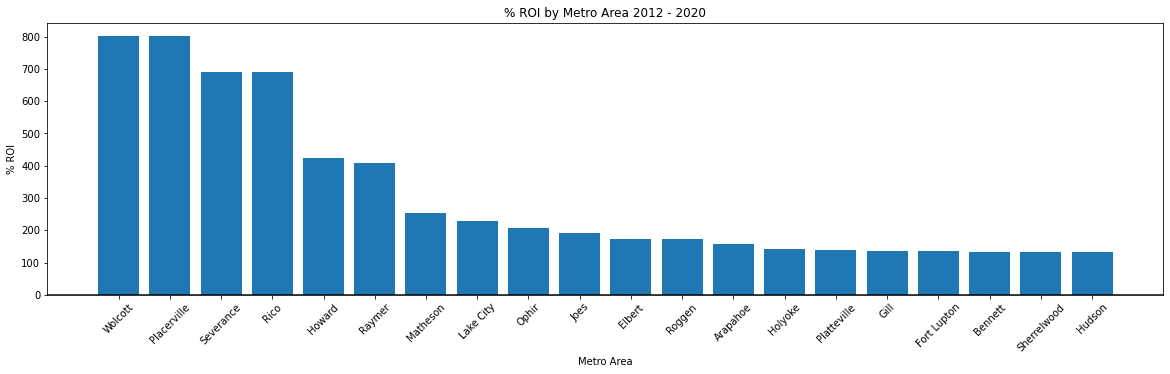

,% ROI
City,
Wolcott,802.17
Placerville,802.17
Severance,689.20
Rico,689.20
Howard,423.86
...,...
Gill,136.15
Fort Lupton,135.76
Bennett,133.04


In [17]:
# These lists will hold the names of each metro area, as well as that area's ROI from 2012 to 2021
names = []
historical_roi = []

# This for loop adds the information to the two lists
for i in range(len(train.columns)):
    
    clean_name = train.columns[i]
    
    initial_val = train[train.columns[i]]['2012-01-31']
    present_val = train[train.columns[i]]['2020-07-31']
    
    roi = round(((present_val - initial_val) / initial_val) * 100, 2)
    
    names.append(clean_name)
    historical_roi.append(roi)

# Turning the data into a pandas dataframe
roi_df = pd.DataFrame()
roi_df['City'] = names
roi_df['% ROI'] = historical_roi
roi_df.sort_values(['% ROI'], inplace=True, ascending=False)
roi_df.set_index('City', inplace=True)
roi_df = roi_df.head(20)

# Plotting the historical data 
fig, ax = plt.subplots(figsize=(20,5))
plt.bar(roi_df.index, roi_df['% ROI'])
plt.title('% ROI by Metro Area 2012 - 2020')
plt.xlabel('Metro Area')
plt.ylabel('% ROI')
plt.xticks(rotation=45)
plt.axhline(0, color='k')
plt.show()

# Displaying our top five choices based on EDA
roi_df.head(20)

# Top 5 choices based on EDA

In [18]:
# Our top five choices based on EDA results
top_5 = ['Wolcott', 'Placerville', 'Severance', 'Rico', 'Howard']

# These two lists will track our buy and sell numbers
buys = []
sells = []

# Getting the median values for 2019 (buys) and 2021 (sells)
for i in top_5:
    buys.append(df_2012[i]['2020-07-31'])
    sells.append(df_2012[i]['2022-07-31'])

# Calculating the ROI we would have achieved
eda_roi = round( ((sum(sells) - sum(buys)) / sum(buys) ) * 100, 2)

# Printing the ROI
print(f'Using an EDA approach, we could have achieved {eda_roi}% ROI from 2019 to 2021')

Using an EDA approach, we could have achieved 96.14% ROI from 2019 to 2021


In [19]:
def run_auto_arima(series_i, df2):
    
    '''Runs a grid search on the series passed in, then instantiates and fits 
    an SARIMAX model with those hyperparameters, then returns that fit model. '''
    
    gridsearch = auto_arima(series_i, exogenous= df2,
                                    start_p = 0,
                                    max_p = 3,
                                    d = None, 
                                    start_q = 0,
                                    max_q = 3,
                                    seasonal=True,
                                    m = 12,
                                    suppress_warnings=True,
                                    test='adf',
                                    start_P=0, 
                                    D=1, 
                                    trace=False,
                                    error_action='ignore',  
                                    stepwise=True
                           )

    #order=gridsearch.order,
    #seasonal_order=gridsearch.seasonal_order,
    
    model = SARIMAX(
    series_i,
    exogenous=df2,     # Array of exogenous regressors, shaped nobs x k.   
    order=(1,1,2),
        
    trend='ct',  
    #seasonal_order=gridsearch.seasonal_order, #The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, 
        
    enforce_invertibility=False, # Whether or not to transform the MA parameters to enforce
                                 #invertibility in the moving average component of the model.
    
    use_exact_diffuse=True, # Whether or not to use exact diffuse initialization for non-stationary states. 
    simple_differencing=False, # Whether or not to use partially conditional maximum likelihood estimation.
    hamilton_representation=False # Whether or not to use the Hamilton representation of an ARMA process.
    )

    return model.fit()

# Function for Running SARIMAX model and making predictions with desired period

In [20]:
def run_arima_model(i, steps, df, df2):
    
    '''This function takes i, representing the index of one of our time series,
    steps, which is the number of periods after the end of the 
    sample you want to make a prediction for, and df, the dataframe the series
    is stored in. It log transforms the series, runs run_auto_arima, gets the 
    forecast from the fit model, and inverse log transforms that forecast series
    back into the original units.'''
 
    
    series = df.iloc[:, i:i+1]
    
    name = series.columns[0]
  
    model = run_auto_arima(series,df2)

    forecast_series = model.get_forecast(steps).summary_frame()
    
    return name, series, forecast_series

# Function that runs the model and  plots the results with confidence interval

In [21]:
def plot_results(i, steps, df, df2):
    
    '''plot_results runs run_arima_model() and plots the results.'''
    
    name, original_series, forecast_series = run_arima_model(i, steps, df, df2)

    fig, ax = plt.subplots(figsize=(15, 7))
    plt.plot(original_series)
    plt.plot(forecast_series['mean'])
    ax.fill_between(forecast_series.index, forecast_series['mean_ci_lower'], 
                    forecast_series['mean_ci_upper'], color='k', alpha=0.1)
    plt.title(name)
    plt.legend(['Original','Predicted'], loc='lower right')
    plt.xlabel('Year')
    plt.ylabel('Median Home Price')
    plt.show()
    
    forecast = round(forecast_series['mean'][11])
    low_int =  round(forecast_series['mean_ci_lower'][11])
    high_int = round(forecast_series['mean_ci_upper'][11])
    
    print(f'12 month forecast: {forecast}')
    print(f'95% confidence that the true future value is between {low_int}, and {high_int}')

# Function for evaluating model if the model works with desired error rate.

In [22]:
def evaluate_models(df1, df2, df3):
    #train, test, exoganous
    '''This function takes in two dataframes (train and test in our case), 
    and returns a dataframe with how accurate the models fit to the train 
    set were in predicting the test set values.'''

    names = []
    actuals = []
    preds = []
    perc_errors = []
    
    for i in range(len(traintry.columns)):
        
        name, series, forecast_series = run_arima_model(i, 24, df1, df3)
        
        clean_name = name
        
        actual_val = df2[name][-1]
        predicted_val = forecast_series.iloc[23, 0]
        error = abs(actual_val - predicted_val)
        percent_error = (error/ actual_val) * 100
        
        names.append(clean_name)
        
        actuals.append(f'{round(actual_val):,}')
        
        preds.append(f'{round(predicted_val):,}')
        perc_errors.append(round(percent_error, 2))
        
        print(train.columns[i], 'done', f'{i+1}/320')
        
    
    results_df = pd.DataFrame(index=names)
    results_df['2022 Actual'] = actuals 
    results_df['2022 Predicted'] = preds
    results_df['% Error'] = perc_errors
    results_df.sort_values(by='% Error', inplace=True)
    
    return results_df

# Function for using making predicitons about the future

In [23]:
def generate_predictions(df, steps, df2): #df2 exagon
    
    '''Similar to evaluate_models(), this function takes in a dataframe,
    and a specific number of steps, and returns a dataframe of the 
    future predictions the specified number of steps past the end of 
    the sample.'''
    
    names = []
    current_vals = []
    pred_vals = []
    net_profits = []
    ROI_strings = []
    
    count = 0
    for i in range(len(df.columns)):
        
        count += 1
        
        name, series, forecast = run_arima_model(i, steps, df, df2)
        
        clean_name = name
        print(clean_name)
        
        a = f'{round(testtry[name][-1]):,}'
        b = a.replace(',','')
             
        cur_val =  int(b)  
        
        #series.iloc[-1, 0]
        
        pred_val = forecast.iloc[steps-1, 0]
        
        f'{round(testtry[name][-1]):,}'
        
        #print(cur_val)
        #print(pred_val)
        
        roi = int(round(((pred_val - cur_val) / cur_val) * 100, 2))
        
        names.append(clean_name)
        
        current_vals.append(f'{round(testtry[name][-1]):,}')
        
        pred_vals.append(f'{round(pred_val):,}')
        
        net_prof = round(pred_val - cur_val , 2)
              
        net_profits.append(f'{round(net_prof):,}')
        
        ROI_strings.append(f'{roi}%') 
        
        #if count == 26:
            #break
    
    
    results_df = pd.DataFrame()
    results_df['City'] = names
    results_df.set_index(['City'])
    results_df['Current Value'] = current_vals
    results_df['2023 / 07 / 31'] = pred_vals
    results_df['Net Profit'] = net_profits
    results_df['ROI'] = ROI_strings
    
    return results_df

# Read the financial indicators that we determined and recorded in the other notebook to add additional features to the model.

In [27]:
mony = pd.read_csv("m1moneysupplymonthly.csv")

In [28]:
ex = pd.DataFrame(data=mony['M1SL'])

In [29]:
velofmoney = pd.read_csv("velocityofmoney.csv")

In [30]:
ex['VelocityOfMoney'] = velofmoney['M2V']

# Helper Features to be used in predicting Colorado citys Future Sale Prices
M1 Money Supply

M2 Velocity of Money

# Creating Extra Features from Money Supply and Velocity

In [31]:
ex['M1SL_Change'] = ex['M1SL'].pct_change()

In [32]:
ex['Velocity_Change'] = ex['VelocityOfMoney'].pct_change()

In [33]:
ex['M1SL_Change'] = ex['M1SL_Change'].fillna(0.002407)                                            

In [34]:
ex['Velocity_Change'] = ex['Velocity_Change'].fillna(0)                                            

In [35]:
exogenous = ex

In [36]:
exogenous.head()

,M1SL,VelocityOfMoney,M1SL_Change,Velocity_Change
0,2201.8,1.648,0.002407,0.000000
1,2207.1,1.648,0.002407,0.000000
2,2227.8,1.648,0.009379,0.000000
3,2237.3,1.642,0.004264,-0.003641
4,2256.2,1.642,0.008448,0.000000


# Since there are 320 different cities, select the desired cities and filter them for training.

In [37]:
traintry = train.iloc[:,60:80]
testtry = test.iloc[:,60:80]

# It can be used this way to train them all.

In [43]:
traintry = train.iloc[:,:]

testtry = test.iloc[:,:]

In [44]:
# This dataframe will show us how accurate our models are 
eval_df = evaluate_models(traintry, testtry, exogenous)

# Displaying the dataframe
eval_df.head()

Agate done 1/320
Aguilar done 2/320
Akron done 3/320
Alamosa done 4/320
Allenspark done 5/320
Alma done 6/320
Almont done 7/320
Antonito done 8/320
Arapahoe done 9/320
Arriba done 10/320
Arvada done 11/320
Aspen done 12/320
Atwood done 13/320
Ault done 14/320
Aurora done 15/320
Avon done 16/320
Avondale done 17/320
Bailey done 18/320
Basalt done 19/320
Bayfield done 20/320
Bellvue done 21/320
Bennett done 22/320
Berthoud done 23/320
Bethune done 24/320
Beulah done 25/320
Black Forest done 26/320
Blanca done 27/320
Bonanza City done 28/320
Boone done 29/320
Boulder done 30/320
Breckenridge done 31/320
Briggsdale done 32/320
Brighton done 33/320
Broomfield done 34/320
Brush done 35/320
Buena Vista done 36/320
Burlington done 37/320
Byers done 38/320
Cahone done 39/320
Calhan done 40/320
Canon City done 41/320
Carbondale done 42/320
Carr done 43/320
Castle Rock done 44/320
Cedaredge done 45/320
Centennial done 46/320
Center done 47/320
Central City done 48/320
Cheyenne Wells done 49/320
C

,2022 Actual,2022 Predicted,% Error
Glenwood Springs,"787,680","787,852",0.02
Norwood,"387,793","387,946",0.04
Salida,"578,557","578,181",0.07
Silverthorne,"1,056,664","1,058,184",0.14
Rangely,"216,936","217,280",0.16


In [45]:
eval_df.to_csv("evalnew.csv")

In [47]:
evaluatedf = pd.read_csv("evalnew.csv")

# We have an error rate of around 10%. We can use the model like this.

In [49]:
evaluatedf['% Error'].mean()

10.334312500000001

In [50]:
# Calculating the average error using the dataframe above 
average_error = str(round(sum([int(i) for i in eval_df['% Error']]) / len(eval_df) , 2)) + '%'

# Printing the result
print(f"On average our model based predictions were {average_error} off from the observed values.")

On average our model based predictions were 9.87% off from the observed values.


In [229]:
eval_df['% Error'].mean()

9.660500000000003

In [51]:
trainfull = df_2012.iloc[:,:]

In [52]:
trainfull = trainfull.iloc[:,:]

In [54]:
trainfull.tail(2)

,Agate,Aguilar,Akron,Alamosa,Allenspark,Alma,Almont,Antonito,Arapahoe,Arriba,...,Wiggins,Wiley,Windsor,Winter Park,Wolcott,Woodland Park,Wray,Yampa,Yoder,Yuma
time,,,,,,,,,,,,,,,,,,,,,
2022-06-30,539737.0,178221.0,188763.0,243437.0,551804.0,565735.0,542119.0,189660.0,184945.0,135283.0,...,413709.0,144464.0,602359.0,747693.0,2228049.0,513540.0,225023.0,458564.0,425652.0,218547.0
2022-07-31,541727.0,181764.0,191491.0,247133.0,542335.0,566277.0,552332.0,192693.0,187459.0,136647.0,...,421257.0,147508.0,603346.0,754128.0,2261206.0,523091.0,228875.0,467601.0,424774.0,221635.0


In [56]:
# Getting predictions from our models for July of 2023
model_predictions_2023 = generate_predictions(trainfull, 12, exogenous)


Agate
541727
600266.8207148049
Aguilar
181764
198860.78008119392
Akron
191491
199513.61532505712
Alamosa
247133
283942.9846241688
Allenspark
542335
566703.955142385
Alma
566277
624657.8993967336
Almont
552332
607543.1760096065
Antonito
192693
211751.79885834653
Arapahoe
187459
205647.55551970055
Arriba
136647
149491.0114798641
Arvada
694792
726622.9067122422
Aspen
2573905
2755719.2838295465
Atwood
302909
336501.05194982357
Ault
494938
538014.3429461697
Aurora
546762
569699.3366905532
Avon
1248670
1410079.7651871284
Avondale
255909
283145.2563704136
Bailey
551354
651228.586592612
Basalt
1204501
1373380.291043258
Bayfield
516979
584538.8563497568
Bellvue
633644
696358.6018402826
Bennett
641271
700564.0597393617
Berthoud
644403
687552.3215686633
Bethune
201636
222404.8732645633
Beulah
376487
422498.2466528446
Black Forest
748188
833841.493336944
Blanca
131585
147163.07026153326
Bonanza City
286161
320739.2970774371
Boone
225810
251210.04492666424
Boulder
1144700
1195881.5286155313
Brecken

In [62]:
model_predictions_2023.to_csv("Predictionss.csv",index=False)

In [63]:
preds = pd.read_csv("Predictionss.csv")

In [68]:
preds = preds.replace({'%': ''}, regex=True)

In [70]:
preds['ROI'] = preds['ROI'].astype('int')

In [85]:
preds.sort_values('ROI',ascending=False).head(10)

,City,Current Value,2023 / 07 / 31,Net Profit,ROI
287,Stratton,"188,605","269,577","80,972",42
229,Ovid,"98,355","132,751","34,396",34
271,Seibert,"177,698","232,586","54,888",30
85,Eldorado Springs,"773,716","996,547","222,831",28
110,Galeton,"714,278","913,306","199,028",27
267,Sanford,"154,964","197,017","42,053",27
153,Julesburg,"136,591","169,775","33,184",24
170,Lake George,"426,244","527,881","101,637",23
93,Fairplay,"540,417","668,665","128,248",23
79,Eads,"109,299","134,470","25,171",23


In [90]:
preds['Net Profit'] = preds['Net Profit'].replace({',': ''}, regex=True)

# Some of the Citys that has most ROI

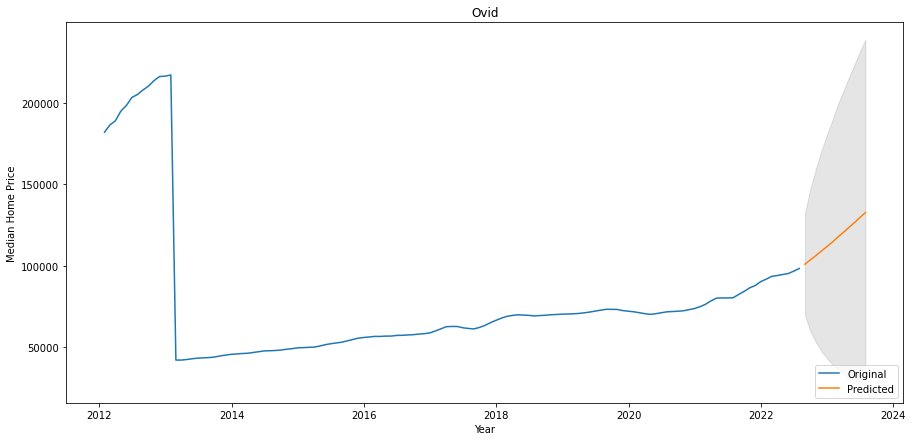

12 month forecast: 132751
95% confidence that the true future value is between 26381, and 239121


In [81]:
plot_results(i=229, steps=12, df=trainfull, df2=exogenous)

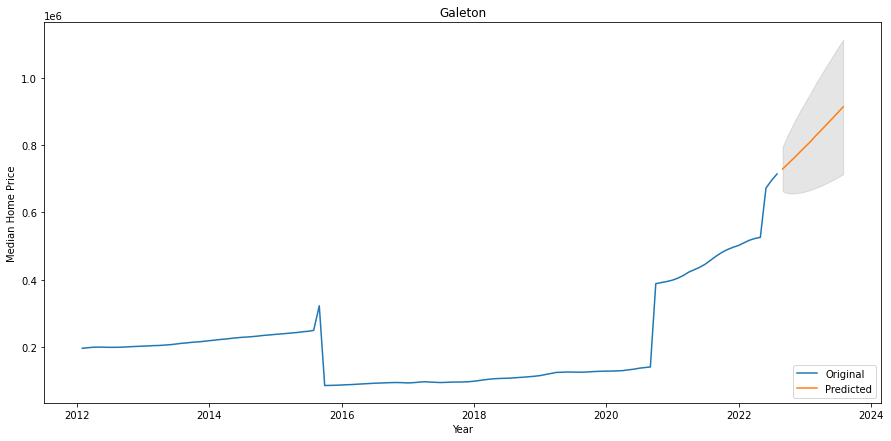

12 month forecast: 913306
95% confidence that the true future value is between 713462, and 1113150


In [84]:
plot_results(i=110, steps=12, df=trainfull, df2=exogenous)

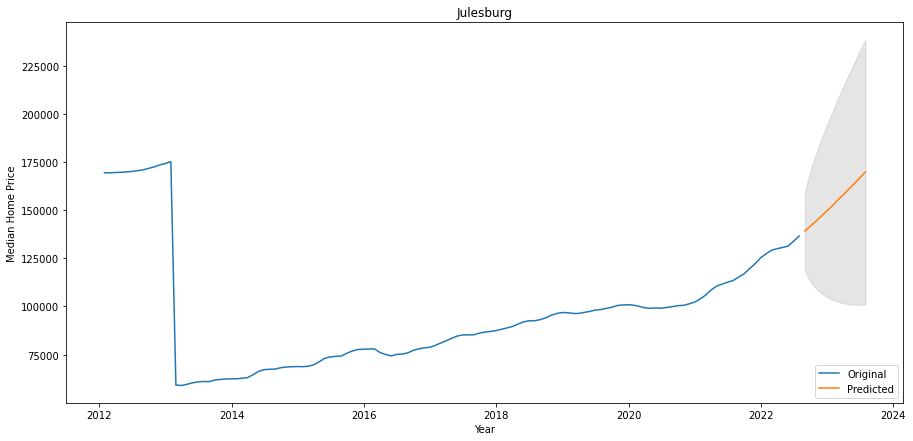

12 month forecast: 169775
95% confidence that the true future value is between 100997, and 238553


In [86]:
plot_results(i=153, steps=12, df=trainfull, df2=exogenous)

# Citys that has most profit in dollars

In [93]:
preds.sort_values('Net Profit',ascending=False).head(10)

,City,Current Value,2023 / 07 / 31,Net Profit,ROI
17,Bailey,"551,354","651,229",99875,18
141,Howard,"495,714","593,448",97734,19
174,Larkspur,"1,025,335","1,121,181",95846,9
42,Carr,"751,900","846,034",94134,12
115,Glenwood Springs,"787,680","881,804",94124,11
62,Crested Butte,"1,065,439","1,158,912",93473,8
252,Raymer,"499,800","591,264",91464,18
106,Fraser,"776,734","866,398",89664,11
218,Nunn,"690,135","779,180",89045,12
159,Kiowa,"746,438","835,026",88588,11


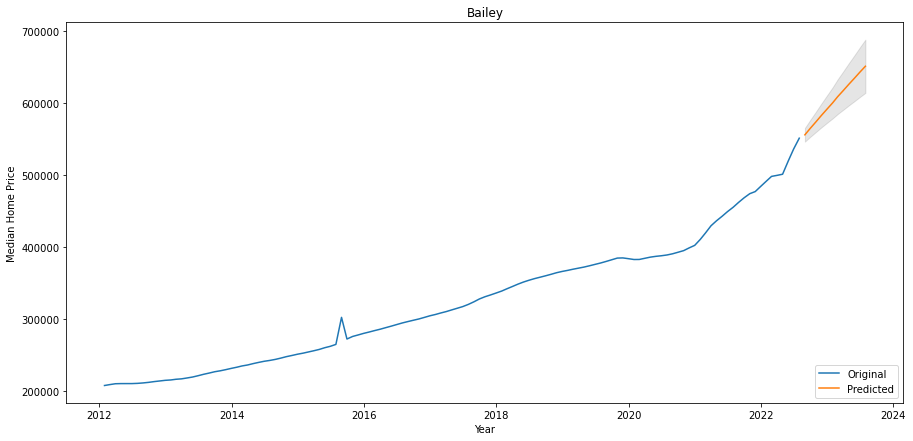

12 month forecast: 651229
95% confidence that the true future value is between 614227, and 688230


In [94]:
plot_results(i=17, steps=12, df=trainfull, df2=exogenous)

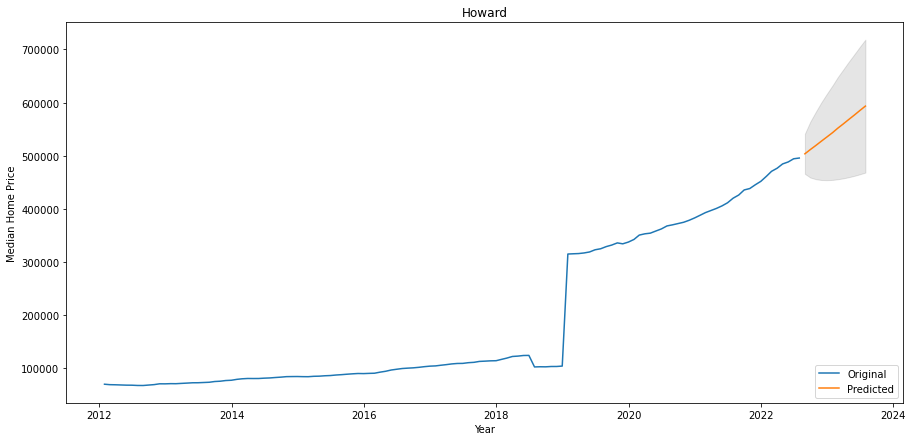

12 month forecast: 593448
95% confidence that the true future value is between 468343, and 718553


In [95]:
plot_results(i=141, steps=12, df=trainfull, df2=exogenous) 

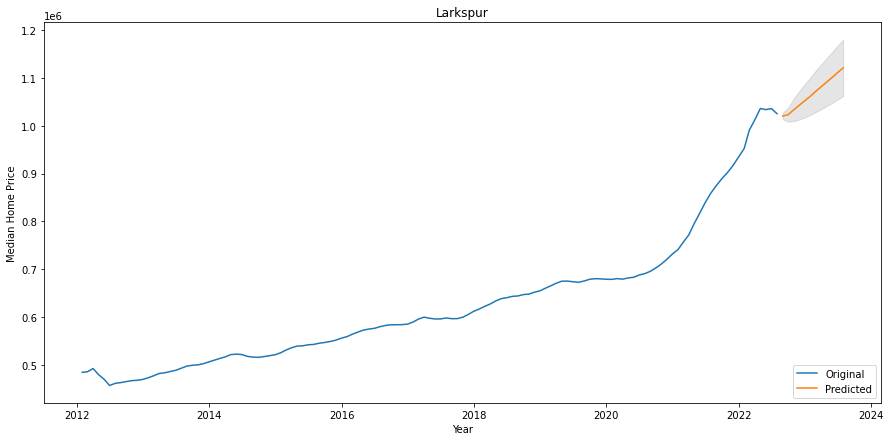

12 month forecast: 1121181
95% confidence that the true future value is between 1061937, and 1180425


In [96]:
plot_results(i=174, steps=12, df=trainfull, df2=exogenous)

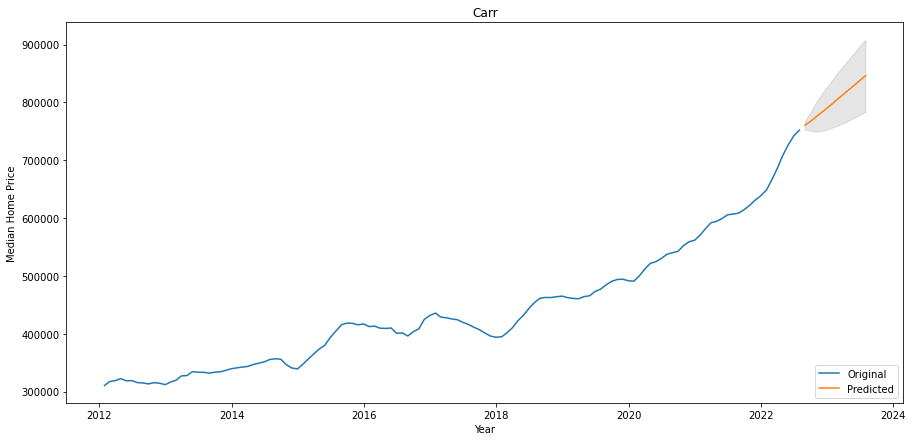

12 month forecast: 846034
95% confidence that the true future value is between 783452, and 908615


In [97]:
plot_results(i=42, steps=12, df=trainfull, df2=exogenous)

In [160]:
top25 = preds.sort_values('ROI',ascending=False).head(25)

In [161]:
top25.head()

,City,Current Value,2023 / 07 / 31,Net Profit,ROI
287,Stratton,"188,605","269,577",80972,42
229,Ovid,"98,355","132,751",34396,34
271,Seibert,"177,698","232,586",54888,30
85,Eldorado Springs,"773,716","996,547",222831,28
110,Galeton,"714,278","913,306",199028,27


In [162]:
top25['City'] = top25['City'].astype('string')

In [163]:
top25.dtypes

City              string
Current Value     object
2023 / 07 / 31    object
Net Profit        object
ROI                int32
dtype: object

In [164]:
top25['City']

287            Stratton
229                Ovid
271             Seibert
85     Eldorado Springs
110             Galeton
             ...       
54     Colorado Springs
95              Flagler
196             McClave
272           Severance
242                Pine
Name: City, Length: 25, dtype: string

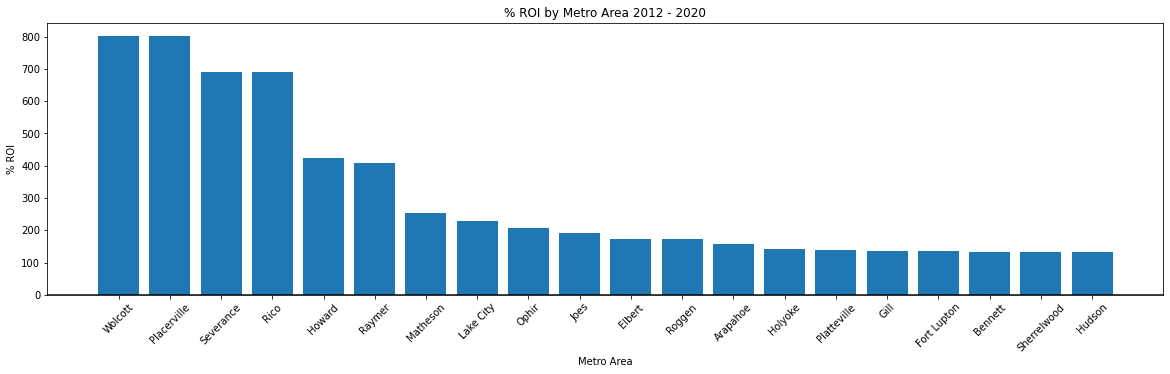

In [140]:
# Plotting the historical data 
fig, ax = plt.subplots(figsize=(20,5))
plt.bar(roi_df.index, roi_df['% ROI'])
plt.title('% ROI by Metro Area 2012 - 2020')
plt.xlabel('Metro Area')
plt.ylabel('% ROI')
plt.xticks(rotation=45)
plt.axhline(0, color='k')
plt.show()

In [165]:
top25

,City,Current Value,2023 / 07 / 31,Net Profit,ROI
287,Stratton,"188,605","269,577",80972,42
229,Ovid,"98,355","132,751",34396,34
271,Seibert,"177,698","232,586",54888,30
85,Eldorado Springs,"773,716","996,547",222831,28
110,Galeton,"714,278","913,306",199028,27
...,...,...,...,...,...
54,Colorado Springs,"513,180","600,004",86824,16
95,Flagler,"193,058","224,190",31132,16
196,McClave,"146,883","171,271",24388,16
272,Severance,"507,366","586,750",79384,15


In [ ]:
import plotly.express as px

fig = px.bar(top25, x='City',y='ROI',
                 labels={
                     "City": "Citys",
                     "ROI": "ROI (%)",
                     
                 },
                title=" Best Regions According to Predicted 2023 ROI " ,
             orientation='v', width=1000, height=500
            )

fig.update_layout(    
    #barmode='group',
    bargap=0.05,         
    bargroupgap=0.15, # gap between bars of the same location coordinate.
    template="simple_white"


)

fig.update_layout(

    title={
        'text': " Predicted ROI 2023 ",
        'y':0.92,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},

    template="simple_white"
    
)

fig.update_layout(
    
    xaxis_tickfont_size=10,
    yaxis_tickfont_size=9.5
)




#fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
#fig.update_layout(uniformtext_minsize=5, uniformtext_mode='hide')

fig.show()


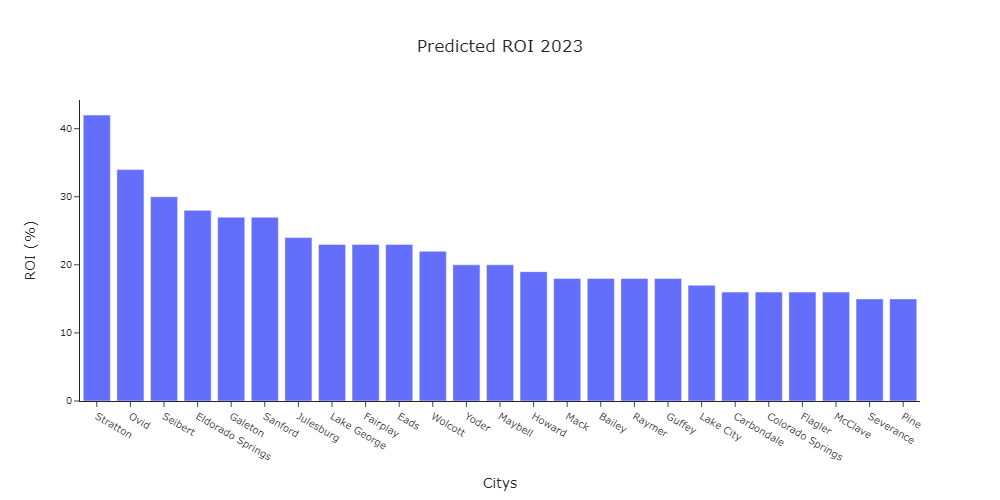